In [1]:
'''
External Data is used in this code, Internet connection is required.

Zone Coordinates were taken from: https://nominatim.openstreetmap.org/
Metro Coordinates were taken from: https://dati.comune.milano.it/dataset/b7344a8f-0ef5-424b-a902-f7f06e32dd67/resource/0f4d4d05-b379-45a4-9a10-412a34708484/download/tpl_metrofermate.csv

All code should run as is, assuming all libraries are installed.
Given data path should be set to the location of the data files on your machine.
Grid-Search and Parameter Tuning might take a while to run depending on your machine.
'''

'\nExternal Data is used in this code, Internet connection is required.\n\nZone Coordinates were taken from: https://nominatim.openstreetmap.org/\nMetro Coordinates were taken from: https://dati.comune.milano.it/dataset/b7344a8f-0ef5-424b-a902-f7f06e32dd67/resource/0f4d4d05-b379-45a4-9a10-412a34708484/download/tpl_metrofermate.csv\n\nAll code should run as is, assuming all libraries are installed.\nGiven data path should be set to the location of the data files on your machine.\nGrid-Search and Parameter Tuning might take a while to run depending on your machine.\n'

In [2]:
import pandas as pd
import numpy as np
import re
import requests
import time
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from sklearn.model_selection import cross_val_score, KFold

warnings.filterwarnings("ignore") 

In [ ]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
METRO_PATH = 'metro_stops_milan.csv_'
train_data = pd.read_csv(TRAIN_PATH)
test_data  = pd.read_csv(TEST_PATH)

#Manually getting Duomo Coordinates
duomo_lat, duomo_lon = 45.4641, 9.1919

## !Data Prep Methods


In [4]:
def clean_contract_type(value):
    if isinstance(value, str):
        for k in ['4+4','3+2','6+6','transitory','students','open','rent']:
            if k in value:
                return k
    return 'rent'

def parse_availability(value):
    if isinstance(value, str) and value.startswith('available from'):
        date = pd.to_datetime(value.replace('available from','').strip(),
                              dayfirst=True, errors='coerce')
        if pd.notnull(date):
            return date.strftime('%B')
    return 'Other'

def parse_description(desc):
    bedrooms = bathrooms = disabled = 0
    kitchen = 'Unknown'
    if isinstance(desc, str):
        m = re.search(r'(\d+)\s+bedrooms?', desc, re.I)
        if m:
            bedrooms = int(m.group(1))
        m = re.search(r'(\d+)\s+bathrooms?', desc, re.I)
        if m:
            bathrooms = int(m.group(1))
        for kt in ['kitchenette','open kitchen','kitchen diner',
                   'kitchen nook','semi-habitable kitchen']:
            if kt in desc.lower():
                kitchen = kt
                break
        if 'disabled' in desc.lower():
            disabled = 1
    return pd.Series([bedrooms, bathrooms, kitchen, disabled],
                     index=['cleaned_bedrooms','cleaned_bathrooms',
                            'cleaned_kitchen_type','cleaned_disabled_friendly'])

def clean_other_features(value):
    if isinstance(value, str):
        return value.replace('pvcdouble exposure','pvc | double exposure')
    return ''

def clean_condition(value):
    if isinstance(value, str):
        v = value.strip().lower()
        if v in ['excellent','good condition','new']:
            return v
    return 'undefined'

def clean_floor(value):
    return 'undefined' if pd.isna(value) else str(value).strip()

efficiency_map = {c: f'Class {c.upper()}' for c in list('abcdefg')}
def clean_efficiency_class(x):
    if pd.isna(x):
        return 'undefined'
    return efficiency_map.get(str(x).lower().strip(), 'undefined')

def get_coordinates(zone):
    url = 'https://nominatim.openstreetmap.org/search'
    params = {'q': f"{zone}, Milan, Italy",'format':'json','limit':1}
    headers = {'User-Agent':'OpenAI GPT-4'}     #Need to define who is using the API, apparently mimicing and llm is effective for this (I havent really used APIs that much so I am not sure if this is the best way to do it, but it works)
    r = requests.get(url, params=params, headers=headers)
    if r.status_code==200 and r.json(): 
        d = r.json()[0]
        return float(d['lat']), float(d['lon'])
    return None, None

def haversine(lat1, lon1, lat2, lon2):
    R=6371
    φ1,φ2 = math.radians(lat1), math.radians(lat2)
    dφ = math.radians(lat2-lat1)
    dλ = math.radians(lon2-lon1)
    a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def haversine_array(lat, lon, lats, lons):
    R = 6371  # km
    φ1 = np.radians(lat)
    φ2 = np.radians(lats)
    dφ = np.radians(lats - lat)
    dλ = np.radians(lons - lon)
    a  = np.sin(dφ/2.0)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2.0)**2
    c  = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def fallback_zone(z): 
    return z.split('-')[0].split('/')[0].strip()


## !Main Method for Data Prep


In [5]:
features = [
    'electric gate','optic fiber','security door','internal exposure',
    'external exposure','closet','balcony','full day concierge',
    'half-day concierge','centralized tv system','furnished',
    'shared garden','window frames in double glass / pvc',
    'window frames in triple glass / metal','window frames in glass / metal',
    'attic','tavern','video entryphone'
]

def data_cleaner(data):
    df = data.copy()

    #Simple Pandas cleaning for the 'basic' columns
    df['cleaned_contract_type']     = df['contract_type'].apply(clean_contract_type)
    df['cleaned_availability']      = df['availability'].apply(parse_availability)
    df[['cleaned_bedrooms','cleaned_bathrooms',
        'cleaned_kitchen_type','cleaned_disabled_friendly']] = \
         df['description'].apply(parse_description)
    df['cleaned_floor']             = df['floor'].apply(clean_floor)
    df['cleaned_conditions']        = df['conditions'].apply(clean_condition)
    df['cleaned_elevator']          = df['elevator'].map(lambda x: 1 if x=='yes' else 0)
    df['cleaned_energy_efficiency'] = df['energy_efficiency_class'].apply(clean_efficiency_class)
    df['cleaned_condominium_fees']  = df['condominium_fees'].fillna(df['condominium_fees'].median())
    df['other_features_cleaned']    = df['other_features'].apply(clean_other_features)

    #Creating the Binary flags for 'other_features'
    for feat in features:
        col = 'cleaned_' + feat.replace(' ', '_')\
                                .replace('/', '_')\
                                .replace('-', '_')\
                                .lower()
        df[col] = df['other_features_cleaned'].apply(lambda x: int(feat in x))

    zone_coords = {}    
    for z in df['zone'].unique():
        lat, lon = get_coordinates(z)
        if lat is None:
            lat, lon = get_coordinates(fallback_zone(z))
        zone_coords[z] = (lat or 0, lon or 0)
        time.sleep(1)   #Avoids the API rate limit

    #API cannot find this zone, so it's hardcoded
    zone_coords['monte rosa - lotto'] = (45.4785, 9.1343)

    df['cleaned_latitude'] = df['zone'].map(lambda z: zone_coords[z][0])
    df['cleaned_longitude'] = df['zone'].map(lambda z: zone_coords[z][1])
    df['cleaned_distance_to_duomo'] = df['zone'].map(
        lambda z: haversine(zone_coords[z][0],
                            zone_coords[z][1],
                            duomo_lat, duomo_lon)
    )

    df = df.drop(columns=[
        'contract_type','availability','description',
        'other_features','other_features_cleaned',
        'conditions','floor','elevator',
        'energy_efficiency_class','condominium_fees'
    ])

    renamed = {
        c: c.replace('cleaned_','').replace('_',' ').title().replace(' ','')
        for c in df.columns if c.startswith('cleaned_')
    }
    prepped = df.rename(columns=renamed)\
                .rename(columns={'square_meters':'SquaredMeters','zone':'Zone'})

    #Rename 'Price' in Train data
    if 'w' in prepped.columns:
        prepped = prepped.drop(columns=['w']).rename(columns={'y':'Price'})
    return prepped

In [6]:
train_data_cleaned = data_cleaner(train_data)
test_data_cleaned  = data_cleaner(test_data)

# !Random Forest


## Base Random Forest Model


In [ ]:
df = train_data_cleaned.copy()
X = pd.get_dummies(df.drop(columns='Price'))
y = df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

rf = RandomForestRegressor(n_estimators=200,
                           max_depth=None,
                           random_state=42,
                           n_jobs=-1)


rf.fit(X_train, y_train)
val_preds = rf.predict(X_val)
print(f"Validation MAE: {mean_absolute_error(y_val, val_preds):.2f}")

Validation MAE: 357.36


## Random Forest with Grid-Search


In [ ]:
df = train_data_cleaned.copy().drop(columns=['Zone'])
cat_cols = df.select_dtypes(include='object').columns
data_enc = pd.get_dummies(df, columns=cat_cols)

X_full = data_enc.drop(columns='Price')
y_full = data_enc['Price']
X_tr, X_va, y_tr, y_va = train_test_split(X_full, y_full,
                                          test_size=0.2,
                                          random_state=42)

param_dist = {
    'n_estimators': [100,200,300,500,1000],
    'max_depth': [10,20,30, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt','log2', 0.5, None]
}

class TqdmRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None, **fit_params):
        total = self.n_iter * self.cv
        with tqdm(total=total, desc="RandomizedSearchCV Progress") as pbar:
            old = self._run_search
            def new_run(evaluate):
                def wrapper(params):
                    out = evaluate(params)
                    pbar.update(self.cv)
                    return out
                return old(wrapper)
            self._run_search = new_run
            return super().fit(X, y, **fit_params)

search = TqdmRandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=6),
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=6
)
search.fit(X_tr, y_tr)

best_rf = search.best_estimator_
val_preds = best_rf.predict(X_va)
print(f"Tuned Validation MAE: {mean_absolute_error(y_va, val_preds):.2f}")
print("Best params:", search.best_params_)

RandomizedSearchCV Progress:   1%|          | 5/500 [01:43<2:50:35, 20.68s/it]

Tuned Validation MAE: 357.34
Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 30}


## Random Forest with Tuned-Parameters


In [ ]:
train_df = train_data_cleaned.copy()
test_df  = test_data_cleaned.copy()

target = 'Price'
exclude_cols = []
features = [c for c in train_df.columns if c != target and c not in exclude_cols]

X_trn = train_df[features]
y_trn = train_df[target]
X_tst = test_df[features]

combined = pd.concat([X_trn, X_tst], keys=['train','test'])
combined = combined.drop(columns=exclude_cols, errors='ignore')
cat_cols = combined.select_dtypes(include='object').columns
combined_enc = pd.get_dummies(combined, columns=cat_cols)

X_trn_enc = combined_enc.xs('train')
X_tst_enc = combined_enc.xs('test').reindex(
    columns=X_trn_enc.columns, fill_value=0
)

final_rf = RandomForestRegressor(
    n_estimators=1000,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features=0.5,
    max_depth=30,
    random_state=42,
    n_jobs=6
)
final_rf.fit(X_trn_enc, y_trn)

test_preds = final_rf.predict(X_tst_enc)
with open("test_predictions_1.txt", "w") as f:
    for v in test_preds:
        f.write(f"{v:.2f}\n")

# !Checking Feature Importance


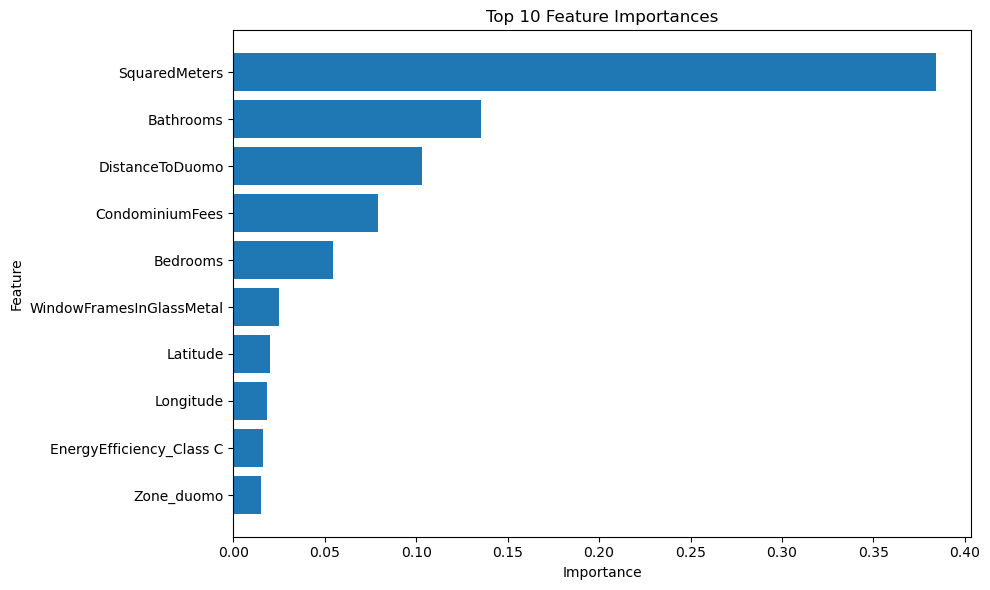

In [ ]:
importances = final_rf.feature_importances_
features    = X_trn_enc.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

top10 = importance_df.head(10)
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(top10['Feature'][::-1], top10['Importance'][::-1])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# !Interactions Terms Model


## !Create Interaction Terms


In [ ]:
data_int = train_data_cleaned.copy()

data_int['sqm_bathrooms']        = data_int['SquaredMeters'] * data_int['Bathrooms']
data_int['sqm_bedrooms']         = data_int['SquaredMeters'] * data_int['Bedrooms']
data_int['bedrooms_bathrooms']   = data_int['Bedrooms'] * data_int['Bathrooms']
data_int['distance_sqm']         = data_int['DistanceToDuomo'] * data_int['SquaredMeters']
data_int['fees_sqm']             = data_int['CondominiumFees'] * data_int['SquaredMeters']
data_int['bathrooms_distance']   = data_int['Bathrooms'] * data_int['DistanceToDuomo']
data_int['bedrooms_fees']        = data_int['Bedrooms'] * data_int['CondominiumFees']


test_int = test_data_cleaned.copy()

test_int['sqm_bathrooms']      = test_int['SquaredMeters'] * test_int['Bathrooms']
test_int['sqm_bedrooms']       = test_int['SquaredMeters'] * test_int['Bedrooms']
test_int['bedrooms_bathrooms'] = test_int['Bedrooms']      * test_int['Bathrooms']
test_int['distance_sqm']       = test_int['DistanceToDuomo'] * test_int['SquaredMeters']
test_int['fees_sqm']           = test_int['CondominiumFees'] * test_int['SquaredMeters']
test_int['bathrooms_distance'] = test_int['Bathrooms'] * test_int['DistanceToDuomo']
test_int['bedrooms_fees']      = test_int['Bedrooms'] * test_int['CondominiumFees']

## !Base Model using Interaction Terms


In [ ]:
y = data_int['Price']
X = data_int.drop(columns='Price')

X = pd.get_dummies(X, drop_first=True)  #One-hot encoding
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf_int = RandomForestRegressor(
    n_estimators=500,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    random_state=42,
    n_jobs=-1
)
rf_int.fit(X_train, y_train)
preds = rf_int.predict(X_val)
print(f"Validation MAE with interactions: {mean_absolute_error(y_val, preds):.2f}")

Validation MAE with interactions: 349.29


# !Metros


## !Get Metro Coordinates


In [7]:
metro_df = pd.read_csv(METRO_PATH, sep=';', quotechar='"')
print(metro_df.shape)

(130, 6)


In [8]:
train_df = train_data_cleaned.copy()
test_df  = test_data_cleaned.copy()

metro_df = metro_df.rename(columns={
    'nome':      'Station',
    'LAT_Y_4326':'MetroLat',
    'LONG_X_4326':'MetroLon'
})[['Station','MetroLat','MetroLon']]

station_lats = metro_df['MetroLat'].values
station_lons = metro_df['MetroLon'].values
station_names = metro_df['Station'].values

def find_nearest_station(row):
    dists = haversine_array(
        row['Latitude'],
        row['Longitude'],
        station_lats,
        station_lons
    )
    idx = np.argmin(dists)
    return pd.Series({
        'NearestMetro':     station_names[idx],
        'DistanceToMetro':  dists[idx]
    })

train_data_metro = train_df.copy()
train_data_metro[['NearestMetro','DistanceToMetro']] = train_data_metro.apply(
    find_nearest_station, axis=1
)

test_data_metro = test_df.copy()
test_data_metro[['NearestMetro','DistanceToMetro']] = test_data_metro.apply(
    find_nearest_station, axis=1
)

In [9]:
data = train_data_metro.copy()

target = 'Price'
features = [col for col in data.columns if col != target]

X = data[features]
y = data[target]

combined = pd.concat([X, data[features]], keys=['train', 'test'])

categorical_cols = combined.select_dtypes(include='object').columns
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

X_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=500, max_depth=30, min_samples_split=2, min_samples_leaf=1, max_features=0.5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

val_preds = rf.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 345.96


# !Metro + Interaction Terms


In [ ]:
metro_int_train = pd.concat([data_int, train_data_metro], axis=1)
metro_int_test = pd.concat([test_int, test_data_metro], axis=1)

In [ ]:
data = metro_int_train.copy()

target = 'Price'
features = [col for col in data.columns if col != target]

X = data[features]
y = data[target]

combined = pd.concat([X, data[features]], keys=['train', 'test'])

categorical_cols = combined.select_dtypes(include='object').columns
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

X_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=500, max_depth=30, min_samples_split=2, min_samples_leaf=1, max_features=0.5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

val_preds = rf.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 352.49


##


# !Final RF Model


In [ ]:
data = train_data_metro.copy()

In [ ]:
target = 'Price'
features = [col for col in data.columns if col != target]

X = data[features]
y = data[target]

combined = pd.concat([X, data[features]], keys=['train', 'test'])

categorical_cols = combined.select_dtypes(include='object').columns
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

X_encoded = combined_encoded.xs('train')
X_test_encoded = combined_encoded.xs('test')

X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=1000, max_depth=30, min_samples_split=2, min_samples_leaf=1, max_features=0.3, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

val_preds = rf.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"Validation MAE: {mae:.2f}")

Validation MAE: 344.66


In [41]:
param_grid = {
    'n_estimators': [500, 750, 1000, 1250],
    'max_depth': [None, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.3, 0.5, 'sqrt', 'log2', None]
}

param_names = list(param_grid.keys())
param_list = [
    dict(zip(param_names, combo))
    for combo in product(*param_grid.values())
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(params):
    model = RandomForestRegressor(**params, random_state=42, n_jobs=1)
    neg_maes = cross_val_score(
        model, X_encoded, y,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_jobs=1  
    )
    mean_mae = -np.mean(neg_maes)
    return mean_mae, params

results = Parallel(n_jobs=10)(      #Reduce n_jobs if you have few cores, machine could crash otherwise
    delayed(evaluate)(p)
    for p in tqdm(param_list, desc="Grid Search (CV)", unit="model")
)

best_mae, best_params = min(results, key=lambda x: x[0])
print(f"Best CV MAE: {best_mae:.2f}")
print("Best params:", best_params)

final_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_rf.fit(X_encoded, y)

Grid Search (CV): 100%|██████████| 720/720 [1:07:39<00:00,  5.64s/model]


Best CV MAE: 338.30
Best params: {'n_estimators': 1000, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}


RandomForestRegressor(max_depth=30, max_features=0.5, n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [44]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=30, min_samples_split=2,
min_samples_leaf=1, max_features=0.3, random_state=42, n_jobs=-1)

In [45]:
model_data = train_data_metro.copy()

X_train = model_data.drop(columns='Price')
y_train = model_data['Price']

X_test = test_data_metro.copy()

combined = pd.concat([X_train, X_test], keys=['train', 'test'])

categorical_cols = combined.select_dtypes(include='object').columns
combined_encoded = pd.get_dummies(combined, columns=categorical_cols)

X_train_encoded = combined_encoded.xs('train')
X_test_encoded  = combined_encoded.xs('test')

X_test_encoded = X_test_encoded.reindex(
    columns=X_train_encoded.columns, 
    fill_value=0
)
final_rf.fit(X_train_encoded, y_train)
test_preds = final_rf.predict(X_test_encoded)

with open("final_test.txt", "w") as f:
    for val in test_preds:
        f.write(f"{val:.2f}\n")

---


---


# Boosting Model - 304


In [46]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold

X = train_data_metro.drop(columns='Price')
y = train_data_metro['Price']

cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
    remainder='passthrough'
)

#This was adjusted to find the best parameters for the HistGradientBoostingRegressor, only the final combination is used in this model as it is just a proof of concept (can use CV grid search to check this and for even more precision we can use a Bayesian approach)
param_grid = {
    'learning_rate':      [0.05],
    'max_iter':           [1500],
    'max_leaf_nodes':     [50],
    'max_depth':          [None],
    'min_samples_leaf':   [5]
}

param_names = list(param_grid.keys())
param_list = [dict(zip(param_names, combo)) for combo in product(*param_grid.values())]

cv = KFold(n_splits=3, shuffle=True, random_state=42)

def evaluate(params):
    model = HistGradientBoostingRegressor(random_state=42, **params, early_stopping=True)
    pipe  = make_pipeline(preprocessor, model)
    # neg MAE across 3 folds
    neg_maes = cross_val_score(
        pipe, X, y,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_jobs=1
    )
    return -np.mean(neg_maes), params

results = Parallel(n_jobs=14)(
    delayed(evaluate)(p)
    for p in tqdm(param_list, desc="HGB Grid Search (3-fold CV)", unit="model")
)

best_mae, best_params = min(results, key=lambda x: x[0])
print(f"\nBest 3-fold CV MAE: {best_mae:.2f}")
print("Best params:", best_params)

final_model = make_pipeline(
    preprocessor,
    HistGradientBoostingRegressor(random_state=42, **best_params)
)
final_model.fit(X, y)

HGB Grid Search (3-fold CV): 100%|██████████| 1/1 [00:00<00:00,  4.80model/s]



Best 3-fold CV MAE: 344.82
Best params: {'learning_rate': 0.05, 'max_iter': 1500, 'max_leaf_nodes': 50, 'max_depth': None, 'min_samples_leaf': 5}


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Zone', 'ContractType',
                                                   'Availability',
                                                   'KitchenType', 'Floor',
                                                   'Conditions',
                                                   'EnergyEfficiency',
                                                   'NearestMetro'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(learning_rate=0.05,
                                               max_iter=1500, max_leaf_nodes=50,
                                               min_samples_leaf=5,
                                               random_state=42))])

In [47]:
# Assuming you have `final_model` trained and `test_data_metro` available

X_test = test_data_metro.drop(columns=['Price'], errors='ignore')
test_preds = final_model.predict(X_test)

with open("Final_Boosting_model_predictions.txt", "w") as f:
    for val in test_preds:
        f.write(f"{val:.2f}\n")

# 302


In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from tqdm.auto import tqdm

X = train_data_metro.drop(columns='Price')
y = train_data_metro['Price'].values
X_test = test_data_metro.drop(columns='Price', errors='ignore')

combined = pd.concat([X, X_test], keys=['train', 'test'])
combined_encoded = pd.get_dummies(
    combined,
    columns=combined.select_dtypes(include='object').columns
)
X_enc_df      = combined_encoded.xs('train')
X_test_enc_df = combined_encoded.xs('test').reindex(columns=X_enc_df.columns, fill_value=0)

X_enc      = X_enc_df.values
X_test_enc = X_test_enc_df.values
y_enc      = y

#set up HGB using parameters found previously
hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_iter=1500,
    max_leaf_nodes=50,
    max_depth=None,
    min_samples_leaf=5
)

#set up random search
class TqdmRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None, **fit_params):
        total_iters = self.n_iter * (self.cv or 1)
        with tqdm(total=total_iters, desc=self.__class__.__name__, unit="fit") as pb:
            orig_run_search = self._run_search
            def wrapped_run_search(evaluate_candidates):
                def wrapped_evaluate(candidates):
                    results = evaluate_candidates(candidates)
                    pb.update(len(candidates) * (self.cv or 1))
                    return results
                return orig_run_search(wrapped_evaluate)
            self._run_search = wrapped_run_search
            return super().fit(X, y, **fit_params)


#tuning XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1)
param_dist_xgb = {
    'n_estimators':     [200, 400, 600, 800, 1000],
    'learning_rate':    [0.01, 0.03, 0.05, 0.1],
    'max_depth':        [4, 6, 8, 10, 12],
    'subsample':        [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 10]
}
search_xgb = TqdmRandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
search_xgb.fit(X_enc, y_enc)
best_xgb = search_xgb.best_estimator_

#tuning CatBoost model
cat = CatBoostRegressor(random_seed=42, verbose=False)
param_dist_cat = {
    'iterations':      [500, 1000, 1500],
    'learning_rate':   [0.01, 0.03, 0.05, 0.1],
    'depth':           [4, 6, 8, 10],
    'l2_leaf_reg':     [1, 3, 5, 7, 10]
}
search_cat = TqdmRandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist_cat,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
search_cat.fit(X_enc, y_enc)
best_cat = search_cat.best_estimator_


#set up lassoCV for stacking
meta = LassoCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
    cv=5,
    n_jobs=-1,
    max_iter=5000
)


#set up stack
stack = StackingRegressor(
    estimators=[
        ('hgb',  hgb),
        ('xgb',  best_xgb),
        ('cat',  best_cat),
    ],
    final_estimator=meta,
    passthrough=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

#train stack on 3 models
stack.fit(X_enc, y_enc)

preds = stack.predict(X_test_enc)
with open("stacked_hgb_xgb_cat_lasso.txt", "w") as f:
    for p in preds:
        f.write(f"{p:.2f}\n")

[I 2025-05-18 23:54:53,691] A new study created in memory with name: no-name-2eb406cb-7eee-4896-a6f9-8710f6d9b421
[I 2025-05-18 23:54:54,936] Trial 0 finished with value: 470.51262374688235 and parameters: {'lam': 31.05691105278062}. Best is trial 0 with value: 470.51262374688235.
[I 2025-05-18 23:54:56,217] Trial 1 finished with value: 457.8577926407486 and parameters: {'lam': 1.2050886921946797}. Best is trial 1 with value: 457.8577926407486.
[I 2025-05-18 23:54:57,517] Trial 2 finished with value: 468.9602506302634 and parameters: {'lam': 19.24931099735872}. Best is trial 1 with value: 457.8577926407486.
[I 2025-05-18 23:54:58,745] Trial 3 finished with value: 453.7073177950668 and parameters: {'lam': 0.020370329427599226}. Best is trial 3 with value: 453.7073177950668.
[I 2025-05-18 23:55:00,024] Trial 4 finished with value: 456.9483921794217 and parameters: {'lam': 0.0037057125433477274}. Best is trial 3 with value: 453.7073177950668.
[I 2025-05-18 23:55:01,246] Trial 5 finished w

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-18 23:58:13,223] Trial 0 finished with value: 342.7063176384945 and parameters: {'learning_rate': 0.006719593176542906, 'num_leaves': 181, 'subsample': 0.9712826439636584, 'colsample_bytree': 0.7075050229246903, 'min_child_samples': 20, 'n_estimators': 873}. Best is trial 0 with value: 342.7063176384945.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1212
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 224
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

[I 2025-05-18 23:58:27,541] Trial 1 finished with value: 334.1050527239265 and parameters: {'learning_rate': 0.03636438235533585, 'num_leaves': 177, 'subsample': 0.7417621591900914, 'colsample_bytree': 0.6023523459696886, 'min_child_samples': 11, 'n_estimators': 281}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 121
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-18 23:58:31,688] Trial 2 finished with value: 350.6794758787956 and parameters: {'learning_rate': 0.07601471489577342, 'num_leaves': 169, 'subsample': 0.7631265865086495, 'colsample_bytree': 0.7756171143584544, 'min_child_samples': 39, 'n_estimators': 240}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 126
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of dat

[I 2025-05-18 23:58:40,074] Trial 3 finished with value: 482.2688127919248 and parameters: {'learning_rate': 0.001864190129191556, 'num_leaves': 43, 'subsample': 0.7952910933950268, 'colsample_bytree': 0.6933132590358976, 'min_child_samples': 37, 'n_estimators': 651}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 132
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-18 23:58:43,470] Trial 4 finished with value: 462.30798396778164 and parameters: {'learning_rate': 0.007369959125813862, 'num_leaves': 238, 'subsample': 0.8869115619893325, 'colsample_bytree': 0.6360706791916105, 'min_child_samples': 35, 'n_estimators': 184}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 23:58:47,500] Trial 5 finished with value: 511.18761102277017 and parameters: {'learning_rate': 0.003622982072335905, 'num_leaves': 167, 'subsample': 0.8238861362036222, 'colsample_bytree': 0.633724470439693, 'min_child_samples': 49, 'n_estimators': 300}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 149
[LightGBM] [Info] Start training from score 196

[I 2025-05-18 23:58:58,721] Trial 6 finished with value: 496.11082376733765 and parameters: {'learning_rate': 0.0021950950086902592, 'num_leaves': 209, 'subsample': 0.6557682237190195, 'colsample_bytree': 0.8996531558388814, 'min_child_samples': 27, 'n_estimators': 475}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 161
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 159
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-18 23:59:15,824] Trial 7 finished with value: 343.6894334885913 and parameters: {'learning_rate': 0.02973405553579789, 'num_leaves': 77, 'subsample': 0.8791623630351141, 'colsample_bytree': 0.9059924408067314, 'min_child_samples': 25, 'n_estimators': 750}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 233
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 244
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-18 23:59:25,710] Trial 8 finished with value: 498.93258352589766 and parameters: {'learning_rate': 0.003213062697198493, 'num_leaves': 107, 'subsample': 0.7984701072282976, 'colsample_bytree': 0.7955326535569299, 'min_child_samples': 10, 'n_estimators': 303}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 121
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-18 23:59:34,389] Trial 9 finished with value: 374.6089795305563 and parameters: {'learning_rate': 0.005659173017877647, 'num_leaves': 114, 'subsample': 0.9831593690853269, 'colsample_bytree': 0.7769172812636732, 'min_child_samples': 39, 'n_estimators': 527}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 272
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 265
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-18 23:59:42,119] Trial 10 finished with value: 367.7276866717252 and parameters: {'learning_rate': 0.021704329850287165, 'num_leaves': 251, 'subsample': 0.6004406235939406, 'colsample_bytree': 0.9447973377423609, 'min_child_samples': 6, 'n_estimators': 102}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1152
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 194
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:00:17,926] Trial 11 finished with value: 336.25432830265294 and parameters: {'learning_rate': 0.016806384361891896, 'num_leaves': 190, 'subsample': 0.7014575307568509, 'colsample_bytree': 0.6892226065553452, 'min_child_samples': 17, 'n_estimators': 955}. Best is trial 1 with value: 334.1050527239265.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 201
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:00:58,890] Trial 12 finished with value: 332.7932732529933 and parameters: {'learning_rate': 0.02773315845423927, 'num_leaves': 206, 'subsample': 0.7040963936623768, 'colsample_bytree': 0.6001987002407808, 'min_child_samples': 15, 'n_estimators': 967}. Best is trial 12 with value: 332.7932732529933.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 201
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 204
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2025-05-19 00:01:15,811] Trial 13 finished with value: 338.1618500814125 and parameters: {'learning_rate': 0.06399212028881346, 'num_leaves': 139, 'subsample': 0.7159378680038163, 'colsample_bytree': 0.6023494902382905, 'min_child_samples': 15, 'n_estimators': 422}. Best is trial 12 with value: 332.7932732529933.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 233
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 244
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Warning] No further 

[I 2025-05-19 00:01:54,504] Trial 14 finished with value: 331.2629124708696 and parameters: {'learning_rate': 0.04164730943269684, 'num_leaves': 216, 'subsample': 0.7098541910770808, 'colsample_bytree': 0.6030519543187013, 'min_child_samples': 10, 'n_estimators': 636}. Best is trial 14 with value: 331.2629124708696.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 272
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 265
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You

[I 2025-05-19 00:02:40,913] Trial 15 finished with value: 326.95209306369253 and parameters: {'learning_rate': 0.014785138439877141, 'num_leaves': 221, 'subsample': 0.6591211088125793, 'colsample_bytree': 0.726938532837488, 'min_child_samples': 6, 'n_estimators': 770}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 280
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 274
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:03:22,887] Trial 16 finished with value: 330.37340471936733 and parameters: {'learning_rate': 0.012354790102951237, 'num_leaves': 216, 'subsample': 0.6274417562260445, 'colsample_bytree': 0.8452828815314422, 'min_child_samples': 5, 'n_estimators': 697}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 280
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 274
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:04:11,791] Trial 17 finished with value: 330.59320825867684 and parameters: {'learning_rate': 0.012886448424041708, 'num_leaves': 227, 'subsample': 0.6044338736192739, 'colsample_bytree': 0.851786626666467, 'min_child_samples': 5, 'n_estimators': 775}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 176
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:04:34,391] Trial 18 finished with value: 343.24186551197437 and parameters: {'learning_rate': 0.01113671873087989, 'num_leaves': 145, 'subsample': 0.6479054020836821, 'colsample_bytree': 0.8454042212599281, 'min_child_samples': 21, 'n_estimators': 795}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 136
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:04:46,783] Trial 19 finished with value: 351.5130190086825 and parameters: {'learning_rate': 0.017019875429977623, 'num_leaves': 248, 'subsample': 0.6654433544595858, 'colsample_bytree': 0.9884291415750286, 'min_child_samples': 32, 'n_estimators': 640}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 280
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 274
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:05:16,728] Trial 20 finished with value: 554.0802437653341 and parameters: {'learning_rate': 0.0010371916238856194, 'num_leaves': 148, 'subsample': 0.6345715150230707, 'colsample_bytree': 0.7395573840075248, 'min_child_samples': 5, 'n_estimators': 706}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 280
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 274
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:06:08,837] Trial 21 finished with value: 330.4724048256721 and parameters: {'learning_rate': 0.01219103773200271, 'num_leaves': 224, 'subsample': 0.6197173344996367, 'colsample_bytree': 0.8420987542786725, 'min_child_samples': 5, 'n_estimators': 838}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 233
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 244
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:06:53,690] Trial 22 finished with value: 335.1587845970127 and parameters: {'learning_rate': 0.009043119035582092, 'num_leaves': 201, 'subsample': 0.6722309174945414, 'colsample_bytree': 0.8441164470221568, 'min_child_samples': 10, 'n_estimators': 853}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 206
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:07:33,087] Trial 23 finished with value: 334.70641394451746 and parameters: {'learning_rate': 0.013776651580708154, 'num_leaves': 224, 'subsample': 0.6243520504267371, 'colsample_bytree': 0.8167227762846503, 'min_child_samples': 13, 'n_estimators': 871}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 254
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 251
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2025-05-19 00:08:07,359] Trial 24 finished with value: 354.9628349386614 and parameters: {'learning_rate': 0.004975639134835027, 'num_leaves': 232, 'subsample': 0.6765382998815979, 'colsample_bytree': 0.8913487726417129, 'min_child_samples': 8, 'n_estimators': 562}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1140
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 188
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:08:30,068] Trial 25 finished with value: 337.797005613513 and parameters: {'learning_rate': 0.019983733785568294, 'num_leaves': 252, 'subsample': 0.6246837290988323, 'colsample_bytree': 0.7433709686158183, 'min_child_samples': 18, 'n_estimators': 688}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 280
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

[I 2025-05-19 00:09:15,267] Trial 26 finished with value: 331.6760416927429 and parameters: {'learning_rate': 0.009252809329791905, 'num_leaves': 195, 'subsample': 0.7464757847650552, 'colsample_bytree': 0.8734939573609961, 'min_child_samples': 5, 'n_estimators': 823}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 106
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-05-19 00:09:28,155] Trial 27 finished with value: 349.8184434134893 and parameters: {'learning_rate': 0.04917571192408073, 'num_leaves': 215, 'subsample': 0.6080571359673976, 'colsample_bytree': 0.7500888515669539, 'min_child_samples': 46, 'n_estimators': 941}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-19 00:09:51,494] Trial 28 finished with value: 337.75643833159523 and parameters: {'learning_rate': 0.011233414072278331, 'num_leaves': 157, 'subsample': 0.6876849230712261, 'colsample_bytree': 0.8208309845121782, 'min_child_samples': 13, 'n_estimators': 569}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 172
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-05-19 00:10:16,357] Trial 29 finished with value: 348.5556662848544 and parameters: {'learning_rate': 0.007180791398598443, 'num_leaves': 184, 'subsample': 0.9017329872448462, 'colsample_bytree': 0.952807718604316, 'min_child_samples': 22, 'n_estimators': 913}. Best is trial 15 with value: 326.95209306369253.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 288
[LightGBM] [Info] Start training from score 1983.720667


[I 2025-05-19 00:10:32,018] A new study created in memory with name: no-name-d6f2b113-0ebc-4389-bb7a-57795b387223
[I 2025-05-19 00:11:29,241] Trial 0 finished with value: 379.30067917880524 and parameters: {'iterations': 1993, 'learning_rate': 0.0018183273449577716, 'depth': 10, 'l2_leaf_reg': 0.0015390947166904465}. Best is trial 0 with value: 379.30067917880524.
[I 2025-05-19 00:11:52,706] Trial 1 finished with value: 455.172928730907 and parameters: {'iterations': 800, 'learning_rate': 0.002206733493605783, 'depth': 10, 'l2_leaf_reg': 0.14562165632617163}. Best is trial 0 with value: 379.30067917880524.
[I 2025-05-19 00:12:05,068] Trial 2 finished with value: 495.0936177490778 and parameters: {'iterations': 1296, 'learning_rate': 0.001124076146615616, 'depth': 8, 'l2_leaf_reg': 0.619200989266899}. Best is trial 0 with value: 379.30067917880524.
[I 2025-05-19 00:12:43,579] Trial 3 finished with value: 432.8095463073221 and parameters: {'iterations': 1343, 'learning_rate': 0.001650010

gam OOF MAE: 456.38
xgb OOF MAE: 321.52
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 281
[LightGBM] [Info] Start training from score 1975.292222
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 277
[LightGBM] [Info] Start training from score 1991.925000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to r

# Improving the stacked model


In [49]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from tqdm.auto import tqdm

# 0) prepare X_enc, y_enc as before…

cv = KFold(n_splits=3, shuffle=True, random_state=42)

# 1) HGB: narrow lam around 0.13 and tweak leaf nodes
hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,       # keep fixed
    max_iter=1500,
    max_depth=None,
    min_samples_leaf=5
)
param_dist_hgb = {
    'max_leaf_nodes': [30, 40, 50, 60, 75],
    'l2_regularization': [0.05, 0.1, 0.13, 0.2, 0.3]
}
search_hgb = RandomizedSearchCV(
    hgb, param_dist_hgb,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=cv, n_jobs=-1, random_state=42,
    verbose=0
)
search_hgb.fit(X_enc, y_enc)
best_hgb = search_hgb.best_estimator_


# 2) XGB: center around your Optuna bests
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)
param_dist_xgb = {
    'n_estimators':    [700, 795, 900],
    'learning_rate':   [0.01, 0.015, 0.02],
    'max_depth':       [9, 11, 13],
    'subsample':       [0.6, 0.7, 0.8],
    'colsample_bytree':[0.55, 0.6, 0.65],
    'min_child_weight':[1, 2]
}
search_xgb = RandomizedSearchCV(
    xgb, param_dist_xgb,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=cv, n_jobs=-1, random_state=42,
    verbose=0
)
search_xgb.fit(X_enc, y_enc)
best_xgb = search_xgb.best_estimator_


# 3) LightGBM: pick a sensible subspace
lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=6)
param_dist_lgb = {
    'n_estimators':    [400, 600, 800],
    'learning_rate':   [0.01, 0.03, 0.05],
    'num_leaves':      [31, 63, 127],
    'subsample':       [0.6, 0.7, 0.8],
    'colsample_bytree':[0.6, 0.7, 0.8]
}
search_lgb = RandomizedSearchCV(
    lgbm, param_dist_lgb,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=cv, n_jobs=-1, random_state=42,
    verbose=0
)
search_lgb.fit(X_enc, y_enc)
best_lgb = search_lgb.best_estimator_


# 4) (optional) CatBoost—if you still want to include it:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(random_seed=42, verbose=False)
param_dist_cat = {
    'iterations':   [800, 1000, 1200],
    'learning_rate':[0.01, 0.03, 0.05],
    'depth':        [8, 10, 12],
    'l2_leaf_reg':  [3, 5, 7]
}
search_cat = RandomizedSearchCV(
    cat, param_dist_cat,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=cv, n_jobs=-1, random_state=42,
    verbose=0
)
search_cat.fit(X_enc, y_enc)
best_cat = search_cat.best_estimator_


# 5) Simple inverse‐MAE blend (0 overhead at predict time)
from sklearn.metrics import mean_absolute_error
maes = np.array([
    mean_absolute_error(y_enc, best_hgb.predict(X_enc)),
    mean_absolute_error(y_enc, best_xgb.predict(X_enc)),
    mean_absolute_error(y_enc, best_lgb.predict(X_enc)),
    mean_absolute_error(y_enc, best_cat.predict(X_enc)),
])
w = (1/maes)
w /= w.sum()

final_preds = (
    w[0]*best_hgb.predict(X_test_enc) +
    w[1]*best_xgb.predict(X_test_enc) +
    w[2]*best_lgb.predict(X_test_enc) +
    w[3]*best_cat.predict(X_test_enc)
)

with open("fast_blend.txt","w") as f:
    for v in final_preds:
        f.write(f"{v:.2f}\n")

print("HGB best MAE:", -search_hgb.best_score_)
print("XGB best MAE:", -search_xgb.best_score_)
print("LGB best MAE:", -search_lgb.best_score_)
print("CAT best MAE:", -search_cat.best_score_)
print("Blend weights:", w)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Total Bins 1120

[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, n

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 177
[LightGBM] [Info] Start training from score 1977.506667
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 177
[LightGBM] [Info] Start training from score 1977.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 196

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002883 secon

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 175
[LightGBM] [Info] Start training from score 200

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 177
[LightGBM] [Info] Start training from score 1977.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 175
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022150 secon

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, n

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 177
[LightGBM] [Info] Start training from score 1977.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135248 secon

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 175
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011351 seconds.
You can set `force_row_wise=true` to 

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 178
[LightGBM] [Info] Start training from score 1964.362667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 175
[LightGBM] [Info] Start training from score 2009.292667
[LightGBM] [Warning] No further splits with positive gain, best ga

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, n

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 3000, n

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140688 secon

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/General_Env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 210
[LightGBM] [Info] Start training from score 1983.720667
HGB best MAE: 328.88737390244654
XGB best MAE: 323.1346130371094
LGB best MAE: 335.6001668827907
CAT best MAE: 334.7437132690023
Blend weights: [0.57353027 0.24278798 0.09404698 0.08963477]
